In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
#merge all data
ditto = pd.read_csv('runs_dittodm_final.csv')
embitto = pd.read_csv('runs_restart_final.csv')
raw_data = pd.concat([ditto, embitto], ignore_index=True)

In [3]:
#raw_data = pd.read_csv("/hpi/fs00/home/lukas.laskowski/Masterarbeit/NumbER/NumbER/scripts/runs_test.csv")
filter_embitto = {
	'lr': 3e-5,
 	'should_finetune': True,
	'should_pretrain': False,
	'matching_solution': 'embitto',
	'finetune_batch_size': 50,
 	'num_finetune_epochs': 40,
	#'num_pretrain_epochs': ??,
	#'pretrain_batch_size': 50,
	'output_embedding_size': 256,
	#'include_numerical_features_in_textual': True,
	#'lm': 'roberta',
	#'fp16': True,
	#'max_len': 256,
	'numerical_config_model': None,
	#'numerical_config_model': None,
	#'numerical_config_model': "NumbER.matching_solutions.embitto.numerical_components.dice.DICEEmbeddingAggregator",
 #'numerical_config_embedding_size': 128,
	# 'numerical_config_finetune_formatter': 'NumbER.matching_solutions.embitto.formatters.pair_based_numeric_formatter',
	# 'numerical_config_pretrain_formatter': 'NumbER.matching_solutions.embitto.formatters.dummy_formatter',
	# 'numerical_config_0': None,
	'textual_config_model': 'NumbER.matching_solutions.embitto.textual_components.base_roberta.BaseRoberta',
	'textual_config_max_length': 256,
	'textual_config_embedding_size': 256,
	'textual_config_finetune_formatter': 'NumbER.matching_solutions.embitto.formatters.complete_prompt_formatter',#_scientific',
	#'textual_config_pretrain_formatter': ??,
	#'textual_config_0': None, 
}
filter_ditto = {
	"batch_size": 50,
	"n_epochs": 40,
	"lr": 3e-5,
	"max_len": 256,
	"lm": "roberta",
	"fp16": True,
 	"matching_solution": "ditto",
}

def get_data(filter):
	filtered_df = raw_data
	for key, value in filter.items():
		if value is not None:
			filtered_df = filtered_df[filtered_df[key] == value]
			#print(len(filtered_df))
		else:
			filtered_df = filtered_df[filtered_df[key].isnull()]
	#print(len(filtered_df))
	filtered_df = filtered_df.drop_duplicates(subset=['tags', 'dataset', 'run'])
	filtered_df = filtered_df[~filtered_df["run"].isnull()]
	filtered_df = filtered_df[filtered_df["dataset"].isin(["x2_all", "x2_merged", "x3_all", "x3_merged", "books3_all", "books3_merged", "books3_all_no_isbn", "books3_merged_no_isbn", "baby_products_all", "baby_products_merged"])]
	#print(filtered_df)
	aggregate = filtered_df.groupby(["dataset", "tags", "state"]).agg({"f1_not_closed": ["mean", "var", "count"], "recall_not_closed": ["mean"], "training_time": ["mean", "std"]})
	return aggregate[aggregate["f1_not_closed"]["count"] > 4]



In [7]:
def build_plot_data(matching_filter):
    aggregate = get_data(matching_filter)
    data = {
		'combined': (
			aggregate[aggregate.index.get_level_values('dataset') == 'x2_merged']["f1_not_closed"]["mean"].values[0],
			aggregate[aggregate.index.get_level_values('dataset') == 'x3_merged']["f1_not_closed"]["mean"].values[0],
			aggregate[aggregate.index.get_level_values('dataset') == 'books3_merged']["f1_not_closed"]["mean"].values[0],
			aggregate[aggregate.index.get_level_values('dataset') == 'books3_merged_no_isbn']["f1_not_closed"]["mean"].values[0],
			aggregate[aggregate.index.get_level_values('dataset') == 'baby_products_merged']["f1_not_closed"]["mean"].values[0]
		),
		'all': (
			aggregate[aggregate.index.get_level_values('dataset') == 'x2_all']["f1_not_closed"]["mean"].values[0],
			aggregate[aggregate.index.get_level_values('dataset') == 'x3_all']["f1_not_closed"]["mean"].values[0],
			aggregate[aggregate.index.get_level_values('dataset') == 'books3_all']["f1_not_closed"]["mean"].values[0],
			aggregate[aggregate.index.get_level_values('dataset') == 'books3_all_no_isbn']["f1_not_closed"]["mean"].values[0],
	aggregate[aggregate.index.get_level_values('dataset') == 'baby_products_all']["f1_not_closed"]["mean"].values[0],
		)
	}
    df = pd.DataFrame(data, index=["Laptops I", "Laptops II", "Books", "BooksNoISBN", "BabyProducts"])
    #df["change"] = df["combined"] / df["all"] - 1
    df["change"] = df["combined"] - df["all"]# - 1
    print(df)
    return df

              combined       all    change
Laptops I     0.931887  0.909354  0.022534
Laptops II    0.803542  0.808187 -0.004645
Books         1.000000  0.998830  0.001170
BooksNoISBN   0.979605  0.983500 -0.003895
BabyProducts  0.911521  0.863831  0.047690
              combined       all    change
Laptops I     0.907615  0.916075 -0.008459
Laptops II    0.728038  0.887604 -0.159566
Books         0.990688  1.000000 -0.009312
BooksNoISBN   0.984459  0.985568 -0.001110
BabyProducts  0.932814  0.921083  0.011731
Index(['Laptops I', 'Laptops II', 'Books', 'BooksNoISBN', 'BabyProducts'], dtype='object')


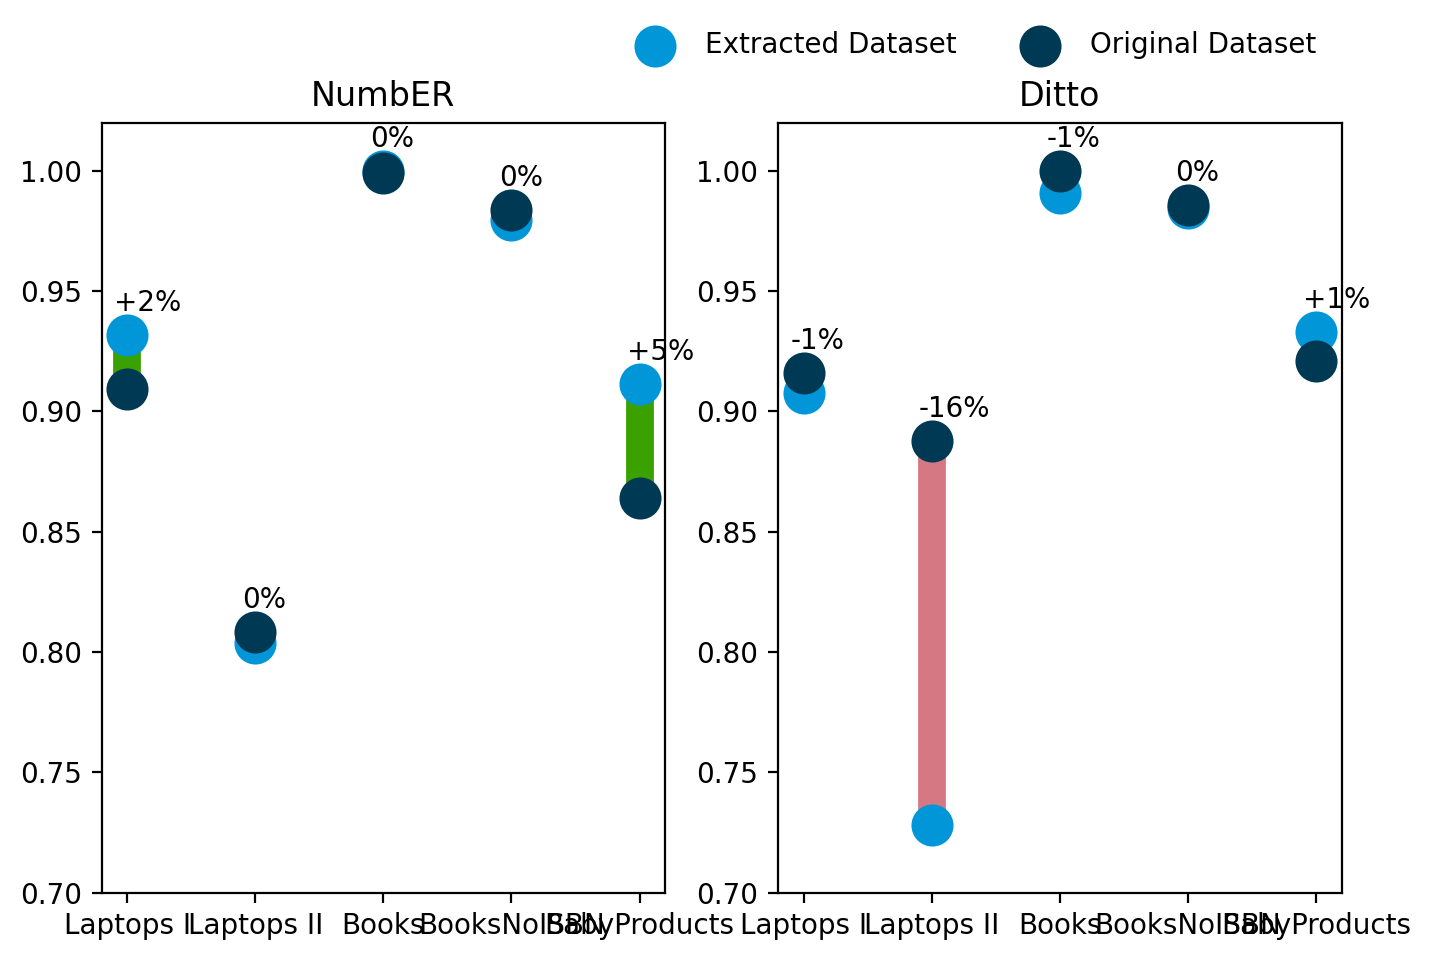

In [8]:

#plt.rcParams['text.usetex'] = True
datasets = ("Laptops I", "Laptops II", "Books", "Books-\nNoISBN", "Baby-\nProducts")
filters = [filter_embitto, filter_ditto]
#for i, filter in enumerate(filters):
plot_data = build_plot_data(filter_embitto)

x = np.arange(len(datasets))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

#df = df.set_index("Country").sort_values("2015")

plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
#plt.figure(figsize=(12,6))
x_range = np.arange(1, len(datasets) + 1)
colors = np.where(plot_data['combined'] > plot_data['all'], '#3ba100', '#d57883')
plt.vlines(x=x_range, ymin=plot_data['combined'], ymax=plot_data['all'],
        color=colors, lw=10)
plt.scatter(x_range, plot_data['combined'], color='#0096d7', s=200, label='Extracted Dataset', zorder=3)
plt.scatter(x_range, plot_data['all'], color='#003953', s=200 , label='Original Dataset', zorder=3)
for (_, row), x in zip(plot_data.iterrows(), x_range):
    value = f"{row['change']:+.0%}" if round(row['change'],2) != 0 else "0%"
    plt.annotate(value, ( x - 0.1, max(row["all"], row["combined"])+0.01))#plt.legend(ncol=2, bbox_to_anchor=(1., 1.01), loc="lower right", frameon=False)
plt.xticks(x_range, plot_data.index)
plt.title("NumbER")
plt.ylim(0.7, 1.02)
#plt.ylabel("F1-Score")
#plt.xlabel("Dataset")
#plt.gcf().subplots_adjust(left=0.35)
#plt.tight_layout()
plt.subplot(1, 2, 2)
plot_data = build_plot_data(filter_ditto)
x_range = np.arange(1, len(datasets) + 1)
colors = np.where(plot_data['combined'] > plot_data['all'], '#3ba100', '#d57883')
plt.vlines(x=x_range, ymin=plot_data['combined'], ymax=plot_data['all'],
        color=colors, lw=10)
plt.scatter(x_range, plot_data['combined'], color='#0096d7', s=200, label='Extracted Dataset', zorder=3)
plt.scatter(x_range, plot_data['all'], color='#003953', s=200 , label='Original Dataset', zorder=3)
for (_, row), x in zip(plot_data.iterrows(), x_range):
    value = f"{row['change']:+.0%}" if round(row['change'],2) != 0 else "0%"
    plt.annotate(value, ( x - 0.1, max(row["all"], row["combined"])+0.01))
plt.legend(ncol=2, bbox_to_anchor=(1., 1.05), loc="lower right", frameon=False)
print(plot_data.index)
plt.xticks(x_range, plot_data.index)
plt.ylim(0.7, 1.02)
#plt.ylabel("F1-Score")
plt.title("Ditto")
#plt.gcf().subplots_adjust(left=0.35)
#plt.tight_layout()
plt.show()

              combined       all    change
Laptops I     0.931887  0.909354  0.022534
Laptops II    0.803542  0.808187 -0.004645
Books         1.000000  0.998830  0.001170
BooksNoISBN   0.979605  0.983500 -0.003895
BabyProducts  0.911521  0.863831  0.047690
              combined       all    change
Laptops I     0.931887  0.909354  0.022534
Laptops II    0.803542  0.808187 -0.004645
Books         1.000000  0.998830  0.001170
BooksNoISBN   0.979605  0.983500 -0.003895
BabyProducts  0.911521  0.863831  0.047690
              combined       all    change
Laptops I     0.907615  0.916075 -0.008459
Laptops II    0.728038  0.887604 -0.159566
Books         0.990688  1.000000 -0.009312
BooksNoISBN   0.984459  0.985568 -0.001110
BabyProducts  0.932814  0.921083  0.011731
Index(['Laptops I', 'Laptops II', 'Books', 'BooksNoISBN', 'BabyProducts'], dtype='object')


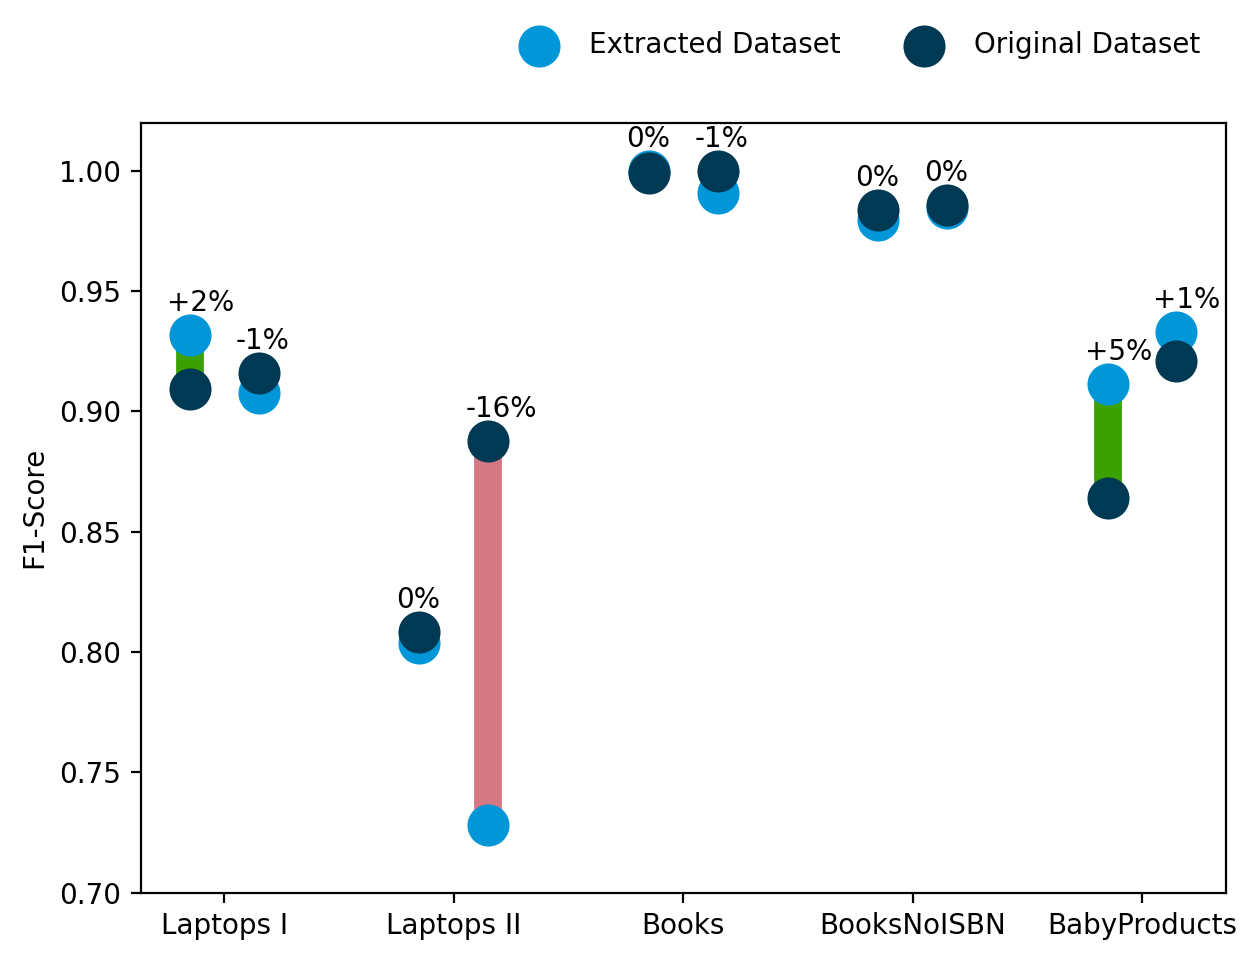

In [9]:
#plt.rcParams['text.usetex'] = True
datasets = ("Laptops I", "Laptops II", "Books", "Books-\nNoISBN", "Baby-\nProducts")
filters = [filter_embitto, filter_ditto]
#for i, filter in enumerate(filters):
plot_data = build_plot_data(filter_embitto)

x = np.arange(len(datasets))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

#df = df.set_index("Country").sort_values("2015")

plt.figure(figsize=(7,5))
plot_data_embitto = build_plot_data(filter_embitto)
plot_data_ditto = build_plot_data(filter_ditto)
x_range = np.arange(1, len(datasets) + 1) #- 0.15
x_range_ditto = np.arange(1, len(datasets) + 1) + 0.3
colors = np.where(plot_data['combined'] > plot_data['all'], '#3ba100', '#d57883')
plt.vlines(x=x_range, ymin=plot_data['combined'], ymax=plot_data['all'],
        color=colors, lw=10)
colors = np.where(plot_data_ditto['combined'] > plot_data_ditto['all'], '#3ba100', '#d57883')
plt.vlines(x=x_range_ditto, ymin=plot_data_ditto['combined'], ymax=plot_data_ditto['all'],
        color=colors, lw=10)
plt.scatter(x_range, plot_data['combined'], color='#0096d7', s=200 , zorder=3)
plt.scatter(x_range, plot_data['all'], color='#003953', s=200 ,  zorder=3)
plt.scatter(x_range_ditto, plot_data_ditto['combined'], color='#0096d7', s=200, label='Extracted Dataset', zorder=3)
plt.scatter(x_range_ditto, plot_data_ditto['all'], color='#003953', s=200 , label='Original Dataset', zorder=3)
for (_, row), x in zip(plot_data.iterrows(), x_range):
    value = f"{row['change']:+.0%}" if round(row['change'],2) != 0 else "0%"
    plt.annotate(value, ( x - 0.1, max(row["all"], row["combined"])+0.01))
for (_, row), x in zip(plot_data_ditto.iterrows(), x_range_ditto):
    value = f"{row['change']:+.0%}" if round(row['change'],2) != 0 else "0%"
    plt.annotate(value, ( x - 0.1, max(row["all"], row["combined"])+0.01))
plt.legend(ncol=2, bbox_to_anchor=(1., 1.05), loc="lower right", frameon=False)
print(plot_data.index)
plt.xticks(x_range+0.15, plot_data.index)
#plt.xticks(x_range, ["NumbER"]*5)
#plt.xticks(x_range_ditto, ["Ditto"]*5)
plt.ylim(0.7, 1.02)
plt.ylabel("F1-Score")
#plt.gcf().subplots_adjust(left=0.35)
#plt.tight_layout()
plt.rcParams["figure.dpi"] = 200

plt.show()
#plt.savefig()

In [4]:
# algorithm,collection,dataset,algo_training_type,algo_input_dimensionality,dataset_training_type,dataset_input_dimensionality,train_preprocess_time,train_main_time,execute_preprocess_time,execute_main_time,execute_postprocess_time,status,error_message,repetition,hyper_params,hyper_params_id,ROC_AUC,PR_AUC,RANGE_PR_AUC,AVERAGE_PRECISION,overall_time,error_category,algo_family,algo_area,algo_display_name
# ARIMA,GutenTAG,cbf-combined-diff-1,GHA,UNIVARIATE,NumbER,UNIVARIATE,,,,71.41411137580872,,Status.OK,,1,"{""differencing_degree"": 1, ""distance_metric"": ""twed"", ""max_lag"": 1000, ""max_p"": 5, ""max_q"": 5, ""p_start"": 1, ""q_start"": 1, ""random_state"": 42, ""window_size"": 100}",c65230762e5361a11b4faac7164f95bf,0.8153191489361702,0.4652479398325147,0.4532154876827748,0.4547417361111111,71.41411137580872,- OK -,forecasting,Statistics (Regression & Forecasting),ARIMA
result_df["algo_display_name"] = result_df["algorithm"]
result_df["algo_training_type"] = result_df["matching_solution"]
result_df["precision"] = result_df["precision_not_closed"]
result_df["f1"] = result_df["f1_not_closed"]
result_df["recall"] = result_df["recall_not_closed"]
result_df["algo_input_dimensionality"] = "TEST"
result_df["dataset_training_type"] = "TEST"
result_df["dataset_input_dimensionality"] = "TEST"
result_df["train_preprocess_time"] = 0
result_df["error_category"] = "- OK -"
result_df["algo_family"] = "forecasting"
result_df["algo_area"] = "Statistics (Regression & Forecasting)"
result_df["collection"] ="TEST"
result_df.to_csv("result_df.csv", index=False)

In [5]:
result_df["algo_display_name"].unique()

array(['complete_prompt_formatter',
       'complete_prompt_formatter_scientific',
       'complete_prompt_formatter_min_max_scaled',
       'textual_prompt_formatter', 'textual_scientific',
       'textual_min_max_scaled', 'pair_based_ditto_formatter',
       'pair_based_ditto_formatter_scientific', 'text_sim_formatter',
       'deep_matcher', 'ditto'], dtype=object)

In [6]:
rename = {
     'pair_based_ditto_formatter': 'Naive',
     'pair_based_ditto_formatter_scientific': 'NaiveScientific',
     'complete_prompt_formatter': 'Distance',
     'complete_prompt_formatter_scientific': 'DistanceScientific',
     'complete_prompt_formatter_min_max_scaled': 'MinMaxDistance',
     'text_sim_formatter': 'TextualDistance',
     'textual_prompt_formatter': 'AttributePair',
     'textual_scientific': 'AttributePairScientific',
     'textual_min_max_scaled': 'AttributePairMinMax',
     'deep_matcher': 'DeepMatcher',
     'ditto': 'Ditto',
}
#rename all values of result_df in column algorithm according to rename
result_df['algorithm'] = result_df['algorithm'].apply(lambda x: rename[x])
result_df.to_csv("result_df.csv", index=False)

In [ ]:
relation_of_numerical_columns = {
	
}